# Training GPR Model on Fuchs Data

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from collections.abc import Iterable
import time
import math 
import sys
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import csv
import os
import gpytorch
import warnings
warnings.filterwarnings("ignore", message="The input matches the stored training data. Did you forget to call model.train()?") 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape
import gc
from tqdm import trange, tqdm
import pynvml
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
dataType = torch.float64
torch.set_default_dtype(dataType)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Exact_GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(Exact_GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Set Noise Level, Dataset, Output Directory

In [2]:
noise = 10 # ADJUST level of gaussian noise added to outputs
mod_type = 'gpr'
description = mod_type + '_noise-' + str(noise)
result_dir = 'results/' + description + '/' # RESULTS stored in this folder
#Check to see if directory exists, make it if it does not
if(not os.path.exists(result_dir)):
    os.makedirs(result_dir)
filename = '../datasets/fuchs_v3-2_seed-5_points_25000_noise_' + str(noise) + '.csv'  # CHANGE TO DESIRED DATA FILE
df = pd.read_csv(filename)

## Get Input

In [3]:
input_list = ['Intensity_(W_cm2)', 'Target_Thickness (um)', 'Focal_Distance_(um)'] # independent variables
output_list = ['Max_Proton_Energy_(MeV)', 'Total_Proton_Energy_(MeV)', 'Avg_Proton_Energy_(MeV)',
               'Max_Proton_Energy_Exact_(MeV)', 'Total_Proton_Energy_Exact_(MeV)', 'Avg_Proton_Energy_Exact_(MeV)'] # training outputs
X = df[input_list].copy()
y = df[output_list].copy()
X[X.columns[0]] = np.log(X[X.columns[0]]) # Apply log scaling to intensity
for col in y.columns:
    y[col] = np.log(y[col]) # Apply log scaling to energy

X = X.to_numpy()
y = y.to_numpy()
    
train_split = 0.8 # Reserve 80% of entire dataset for training
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, train_size=train_split, shuffle = False)
y_train_full = y_train_full[:, 0:3]
y_test_full = y_test_full[:, 0:6] # Includes noisy data and exact fuchs data

## Specify Hyper-parameters and Initialize Variables

In [4]:
num_epochs = 30
lr = 2e-1

num_inputs = X_train_full.shape[1]
num_outputs = y_train_full.shape[1]
    
num_splits = 40
data_fractions =  np.linspace(1/num_splits, 1, num_splits) # 1k, 2k, ..., 20k training points
points_train = np.round(data_fractions*len(X_train_full)).astype(int)
points_test = np.round(data_fractions*len(X_test_full)).astype(int)
print('training points: ', points_train)

time_list = np.zeros(num_splits)
train_mse = np.zeros((num_splits, num_outputs))
train_mape = np.zeros((num_splits, num_outputs))
test_mse_noisy = np.zeros((num_splits, num_outputs))
test_mape_noisy = np.zeros((num_splits, num_outputs))
test_mse_exact = np.zeros((num_splits, num_outputs))
test_mape_exact = np.zeros((num_splits, num_outputs))
test_mape_exact_uncorrected = np.zeros((num_splits, num_outputs))
mem_used = np.zeros((num_splits, num_outputs))

training points:  [  500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500  6000
  6500  7000  7500  8000  8500  9000  9500 10000 10500 11000 11500 12000
 12500 13000 13500 14000 14500 15000 15500 16000 16500 17000 17500 18000
 18500 19000 19500 20000]


## Training Loop

In [5]:
print('theoretical correction factor: ', round(np.sqrt(1 + (noise/100)**2), 3))
outs = ['max', 'tot', 'avg']
pbar = trange(num_splits, desc='training split', leave=True)
for i in pbar:

    X_train = X_train_full[0:points_train[i], 0:num_inputs].copy()
    y_train = y_train_full[0:points_train[i]].copy()

    X_test = X_test_full[0:points_test[i], 0:num_inputs].copy()
    y_test_noisy = y_test_full[0:points_test[i]].copy()
    y_test_exact = y_test_full[0:points_test[i], num_inputs:num_inputs+num_outputs].copy()
    
    # StandardScaler: z-score normalization
    ss_in = StandardScaler()
    ss_in.fit(X_train)
    X_train_norm = torch.tensor(ss_in.transform(X_train), device=device, dtype=dataType)
    X_test_norm = torch.tensor(ss_in.transform(X_test), device=device, dtype=dataType)
    
    ss_out = StandardScaler()
    ss_out.fit(y_train)
    y_train_norm = torch.tensor(ss_out.transform(y_train), device=device, dtype=dataType)

    start_time = time.time()
    
    for j in range(num_outputs):
        # Train GPR
        likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
        model = Exact_GP(X_train_norm, y_train_norm[:, j], likelihood).to(device)
    
        model.train()
        likelihood.train()

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
        current_it = 0
        #with gpytorch.settings.max_cg_iterations(value=2000):
        while(current_it < num_epochs):
            # Zero the Gradients
            optimizer.zero_grad()

            # Perform Forward Pass
            model_output = model(X_train_norm)

            # Compute Loss
            loss = -mll(model_output, y_train_norm[:, j])

            # Perform Backward Pass
            loss.backward()

            # Clear cache
            gc.collect()
            torch.cuda.empty_cache()
            current_it += 1

            # Optimization
            optimizer.step()

        model.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            # Make Predictions
            pred_dist_train = likelihood(model(X_train_norm))
            pred_dist_test = likelihood(model(X_test_norm))
            y_train_predict = pred_dist_train.mean
            y_test_predict = pred_dist_test.mean
            y_train_predict_unscaled = np.exp(ss_out.inverse_transform(y_train_predict.cpu().detach().numpy().reshape(-1, 1).repeat(3, 1)))[:, j]
            y_test_predict_unscaled = np.exp(ss_out.inverse_transform(y_test_predict.cpu().detach().numpy().reshape(-1, 1).repeat(3, 1)))[:, j]

            # Corrections due to Log Scaling
            correction_factor = np.mean(np.exp(y_train[:, j])/y_train_predict_unscaled) 
            y_train_predict_corrected = y_train_predict_unscaled*correction_factor
            y_test_predict_corrected = y_test_predict_unscaled*correction_factor

            # Record Metrics
            train_mse[i, j] = mse(np.exp(y_train[:, j]), y_train_predict_corrected)
            train_mape[i, j] = mape(np.exp(y_train[:, j]), y_train_predict_corrected)
            test_mse_noisy[i, j] = mse(np.exp(y_test_noisy[:, j]), y_test_predict_corrected)
            test_mape_noisy[i, j] = mape(np.exp(y_test_noisy[:, j]), y_test_predict_corrected)
            test_mse_exact[i, j] = mse(np.exp(y_test_exact[:, j]), y_test_predict_corrected)
            test_mape_exact[i, j] = mape(np.exp(y_test_exact[:, j]), y_test_predict_corrected)
            test_mape_exact_uncorrected[i, j] = mape(np.exp(y_test_exact[:, j]), y_test_predict_unscaled)
        
        # Record memory usage 
        if device == torch.device("cuda:0"):         
            mem = pynvml.nvmlDeviceGetMemoryInfo(handle)
            mem_used[i, j] = mem.used/2**30
            
        pbar.set_postfix({'test mape':str(round(test_mape_exact[i, j]*100, 2)), 'corr fac': str(round(correction_factor, 3)), 'E': outs[j], 'mem': round(mem_used[i,j], 2)})
            
        # Append output to input for next iteration in chained output regression
        X_train_norm = torch.concat([X_train_norm, y_train_predict.reshape(-1, 1)], axis=1)
        X_test_norm = torch.concat([X_test_norm, y_test_predict.reshape(-1, 1)], axis=1)
            
        gc.collect()
        torch.cuda.empty_cache()
    
    end_time = time.time()
    time_list[i] = end_time - start_time

theoretical correction factor:  1.005


training split: 100%|██████████| 40/40 [10:21<00:00, 15.53s/it, test mape=0.93, corr fac=1.007, E=avg, mem=13.3]


## GPU Memory Consumption

Text(0, 0.5, 'Average GPU Memory (GiB)')

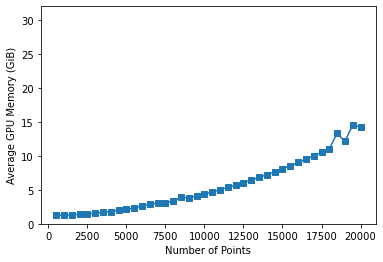

In [6]:
fig, ax = plt.subplots()
ax.plot(points_train, np.mean(mem_used, axis=1), marker='s')
ax.set_ylim([0, 32])
ax.set_xlabel("Number of Points")
ax.set_ylabel("Average GPU Memory (GiB)")
#fig.savefig(result_dir+'gpu_mem.png')

total run time:  619.835364818573  s


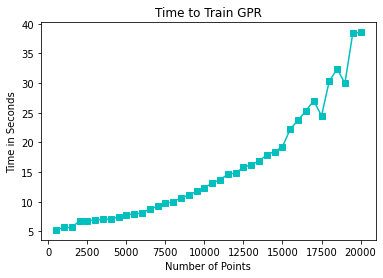

In [7]:
print('total run time: ', sum(time_list), ' s')
fig, ax = plt.subplots()
ax.set_title("Time to Train {}".format(mod_type.upper()))
ax.set_xlabel("Number of Points")
ax.set_ylabel("Time in Seconds")
ax.plot(points_train, time_list, marker='s', c='c', label='Time')
#fig.savefig(result_dir+'time.png')

## Mean Squared Error

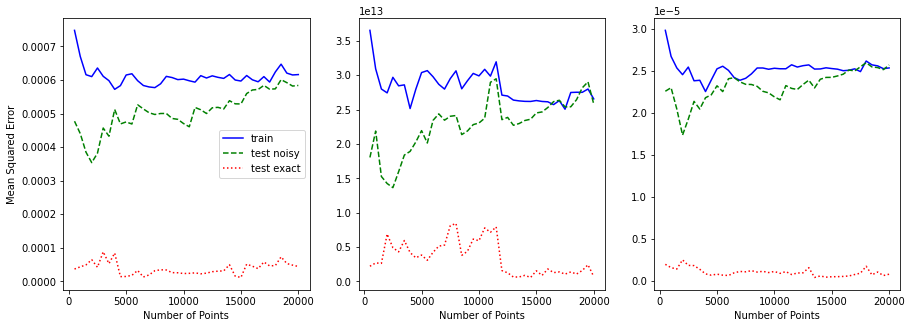

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for j in range(num_outputs):
    ax[j].plot(points_train, train_mse[:, j], c='b', label='train')
    ax[j].plot(points_train, test_mse_noisy[:, j], c='g', label='test noisy', linestyle='dashed')
    ax[j].plot(points_train, test_mse_exact[:, j], c='r', label='test exact', linestyle='dotted')
    ax[j].set_xlabel("Number of Points")
ax[0].set_ylabel("Mean Squared Error")
ax[0].legend(loc='center right')

## Mean Absolute Percentage Error

total run time:  619.835364818573  s


Text(0, 0.5, 'Mean Absolute Percentage Error')

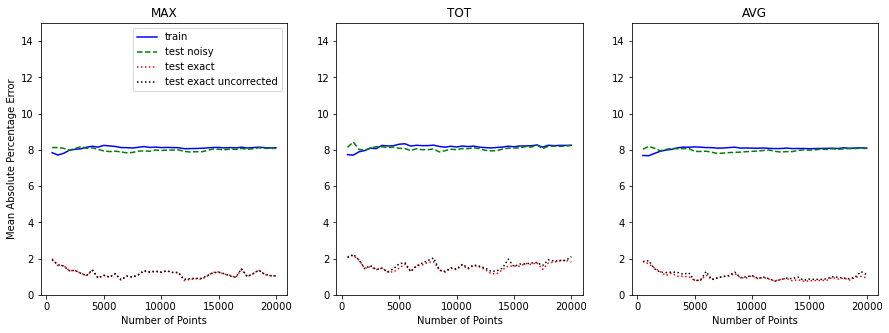

In [9]:
print('total run time: ', sum(time_list), ' s')
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for j in range(num_outputs):
    ax[j].plot(points_train, train_mape[:, j]*100, c='b', label='train')
    ax[j].plot(points_train, test_mape_noisy[:, j]*100, c='g', label='test noisy', linestyle='dashed')
    ax[j].plot(points_train, test_mape_exact[:, j]*100, c='r', label='test exact', linestyle='dotted')
    ax[j].plot(points_train, test_mape_exact_uncorrected[:, j]*100, c='k', label='test exact uncorrected', linestyle='dotted')
    ax[j].set_xlabel("Number of Points")
    ax[j].set_ylim(0, noise+5)
    ax[j].set_title(outs[j].upper())
ax[0].legend(loc='upper right')
ax[0].set_ylabel("Mean Absolute Percentage Error")

## Store Metrics to CSV File

In [10]:
columns = ['train_points', 'gpu_memory', 'time', 
            'train_mse_max', 'train_mse_tot', 'train_mse_avg',
            'test_mse_noisy_max', 'test_mse_noisy_tot', 'test_mse_noisy_avg',
            'test_mse_exact_max', 'test_mse_exact_tot', 'test_mse_exact_avg',
            'train_mape_max', 'train_mape_tot', 'train_mape_avg',
            'test_mape_noisy_max', 'test_mape_noisy_tot', 'test_mape_noisy_avg',
            'test_mape_exact_max', 'test_mape_exact_tot', 'test_mape_exact_avg',
            'test_mape_exact_uncorrected_max', 'test_mape_exact_uncorrected_tot', 'test_mape_exact_uncorrected_avg']
data = [points_train, np.mean(mem_used, axis=1), time_list,
        train_mse[:, 0], train_mse[:, 1], train_mse[:, 2],
        test_mse_noisy[:, 0], test_mse_noisy[:, 1], test_mse_noisy[:, 2],
        test_mse_exact[:, 0], test_mse_exact[:, 1], test_mse_exact[:, 2],
        train_mape[:, 0], train_mape[:, 1], train_mape[:, 2],
        test_mape_noisy[:, 0], test_mape_noisy[:, 1], test_mape_noisy[:, 2],
        test_mape_exact[:, 0], test_mape_exact[:, 1], test_mape_exact[:, 2],
        test_mape_exact_uncorrected[:, 0], test_mape_exact_uncorrected[:, 1], test_mape_exact_uncorrected[:, 2]]
output_df = pd.DataFrame(dict(zip(columns, data)))
display(output_df)

,train_points,gpu_memory,time,train_mse_max,train_mse_tot,train_mse_avg,test_mse_noisy_max,test_mse_noisy_tot,test_mse_noisy_avg,test_mse_exact_max,...,train_mape_avg,test_mape_noisy_max,test_mape_noisy_tot,test_mape_noisy_avg,test_mape_exact_max,test_mape_exact_tot,test_mape_exact_avg,test_mape_exact_uncorrected_max,test_mape_exact_uncorrected_tot,test_mape_exact_uncorrected_avg
0,500,1.250203,5.258935,0.000748,3.653379e+13,0.000030,0.000477,1.803518e+13,0.000023,0.000037,...,0.076893,0.081270,0.081401,0.080328,0.019917,0.021040,0.018511,0.019282,0.020514,0.018260
1,1000,1.279500,5.682761,0.000670,3.093133e+13,0.000027,0.000441,2.187393e+13,0.000023,0.000043,...,0.076766,0.081267,0.084329,0.081945,0.016105,0.021722,0.017061,0.016596,0.022314,0.018834
2,1500,1.314006,5.672631,0.000616,2.799507e+13,0.000025,0.000385,1.526054e+13,0.000020,0.000049,...,0.077992,0.080851,0.080195,0.080905,0.016212,0.019105,0.014745,0.015890,0.019239,0.014382
3,2000,1.405802,6.811573,0.000610,2.743481e+13,0.000025,0.000354,1.423958e+13,0.000017,0.000065,...,0.079215,0.079797,0.079828,0.079482,0.013373,0.014617,0.012841,0.013267,0.014409,0.012483
4,2500,1.469604,6.808041,0.000636,2.969716e+13,0.000025,0.000382,1.364086e+13,0.000019,0.000042,...,0.079876,0.080764,0.081045,0.080201,0.013380,0.015532,0.010591,0.013466,0.016134,0.012236
5,3000,1.555542,6.939296,0.000611,2.846174e+13,0.000024,0.000457,1.596156e+13,0.000021,0.000088,...,0.080268,0.081748,0.081718,0.080877,0.011911,0.013871,0.011962,0.011847,0.013936,0.012544
6,3500,1.681193,7.041804,0.000598,2.859830e+13,0.000024,0.000433,1.838014e+13,0.000020,0.000053,...,0.081112,0.080844,0.081751,0.080571,0.010622,0.014739,0.010286,0.010519,0.014748,0.012376
7,4000,1.808797,7.117251,0.000572,2.515228e+13,0.000023,0.000512,1.891626e+13,0.000022,0.000084,...,0.081514,0.081075,0.081163,0.080692,0.013387,0.012602,0.010116,0.013825,0.012484,0.011361
8,4500,2.015177,7.459252,0.000583,2.797395e+13,0.000024,0.000469,2.028915e+13,0.000022,0.000014,...,0.081434,0.080313,0.081484,0.080736,0.009237,0.012578,0.010041,0.009360,0.014387,0.012078
9,5000,2.157104,7.803779,0.000615,3.038797e+13,0.000025,0.000475,2.193666e+13,0.000023,0.000015,...,0.081623,0.079402,0.080839,0.079147,0.010758,0.014731,0.007925,0.010727,0.017161,0.007936


In [11]:
output_df.to_csv(result_dir + 'metrics.csv', index=False)